In [1]:
library(metacell)
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(devtools)
library(reshape2)
library(plyr)
library(dplyr)
library(tibble)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(tidyr)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)


Attaching package: ‘googledrive’


The followi

# Initializing DBs

In [2]:
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
#> initializing scdb to testdb/

initializing scdb to scdb/



In [3]:
if(!dir.exists("neutrophil_singlet_figs")) dir.create("neutrophil_singlet_figs/")
scfigs_init("neutrophil_singlet_figs/")

In [4]:
mc = scdb_mc("neutrophil_mc")
mat = scdb_mat("neutrophil_singlets")

In [5]:
bad_genes = readr::read_lines('annotations/neutrophil_filtered_genes.txt')

In [6]:
table(mat@cell_metadata[mc@cell_names,'Cell_type'])


CD45+  LY6G 
  258   508 

In [7]:
table(mat@cell_metadata[mc@cell_names,'Age'])


 3w  6w  8w 10d 10w 12w 
 61  31  81 229  99 265 

In [8]:
table(mat@cell_metadata[mc@cell_names,'condition'])


normal  tumor 
   207    559 

In [9]:
length(mc@cell_names)

[1] 766

In [11]:
library(devtools)
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/metacell_functions.r")
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/pic_parser.r")
library(GEOquery)

ℹ SHA-1 hash of file is "bda7f06ee7b168c0be4c723ee15644ab99e6421e"
Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: RANN

Loading required package: plotrix

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:plotrix’:

    plotCI


The following object is masked from ‘package:IRanges’:

    space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:stats’:

    lowess


Loading required package: parallel

Loading required package: compositions

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:IRanges’:

    cor, cov, var


The following objects are masked from ‘package:S4Vectors’:

    cor, cov, var


The following objects are masked from ‘package:BiocGeneri

In [13]:
type_colors = c("chartreuse", "magenta")
names(type_colors) = c('LY6G', 'CD45+')

In [57]:
age_colors = RColorBrewer::brewer.pal(9, "BuPu")[3:8]#c("aquamarine", "cyan", "steelblue", "darkorchid4", "brown1", "deeppink")
#age_colors = colorRampPalette(c("plum1", "magenta4"))(6)
names(age_colors) = c('10d', '3w', '6w', '8w', '10w', '12w')

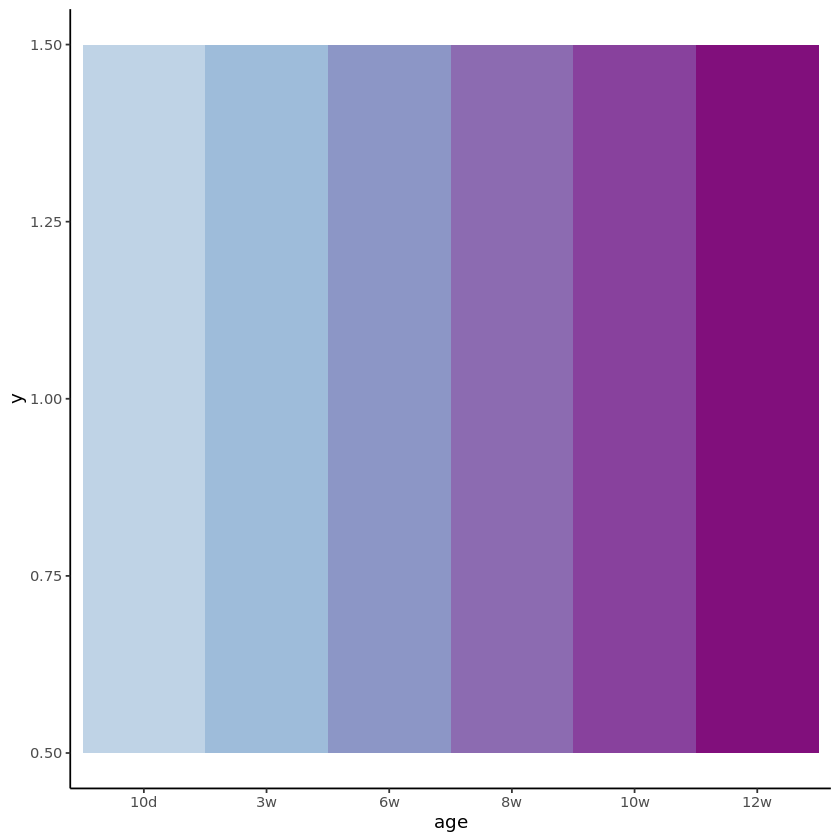

In [58]:
ggplot(data.frame(age=factor(names(age_colors), levels=names(age_colors)), color=age_colors),
                                                                       aes(x=age, y=1, fill=age_colors)) +
    geom_tile() +
    scale_fill_identity()

stage_colors = c("orchid1", "magenta3", "maroon4", "darkorchid4")
names(stage_colors) = c('Prepuberty', 'Neoplasia', 'Early carcinoma', 'Late carcinoma')

In [29]:
cond_colors= c('orange', 'steelblue1')
names(cond_colors) = c('tumor', 'normal')

# Visulations etc

In [30]:
annot_df <- read.csv("annotations/neutrophil_annots.csv", sep=",")

In [31]:
mat = scdb_mat("neutrophil_singlets")
mc = scdb_mc("neutrophil_mc")

In [33]:
for (i in 1:length(unique(annot_df$label))){
    message(paste(i, unique(annot_df$label)[i], sep=": "))
}

1: Ptgs2 high

2: AP high

3: TAN1

4: TAN2

5: TAN3

6: Cystatin high

7: Young Cystatin high



In [34]:
order_index = c(7, 6, 2, 1, 3:5)
cell_order = unique(annot_df$label)[order_index]

In [35]:
good_cellnames = names(mc@mc[mc@annots[mc@mc] %in% cell_order])

In [36]:
unique(annot_df$label)[which(!1:length(unique(annot_df$label)) %in% order_index)]

character(0)

In [37]:
cat(cell_order, sep = '", "')

Young Cystatin high", "Cystatin high", "AP high", "Ptgs2 high", "TAN1", "TAN2", "TAN3

In [38]:
png("neutrophil_singlet_figs/legend.png", width = 3600, height = 1800, units = "px", res = 400)
par(family = "Times New Roman")
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="left", ncol = 2,
       legend=unique(annot_df$label)[order_index],
       fill=unique(annot_df$color)[order_index],
       xpd = TRUE)
dev.off()

png 
  2

In [39]:
auto_markers = names(scdb_gset("neutrophil_markers")@gene_set)

In [40]:
bad_genes = as.character(read_lines('annotations/neutrophil_filtered_genes.txt'))

In [41]:
rp_markers = grep("Rpl|Rps|Snor|Gm|Ig[h,k,l]v|^mt-|Hist|Hsp|Jun|Rik", colnames(mat@mat), v=T)

In [42]:
m2d = scdb_mc2d("neutrophil_2dproj")

In [43]:
mc_2d = data.frame(x=m2d@sc_x[good_cellnames], 
                   y=m2d@sc_y[good_cellnames], 
                   annotation=mc@annots[mc@mc[good_cellnames]])

In [44]:
group.colors = annot_df$color[match(cell_order, annot_df$label)]
names(group.colors) = cell_order

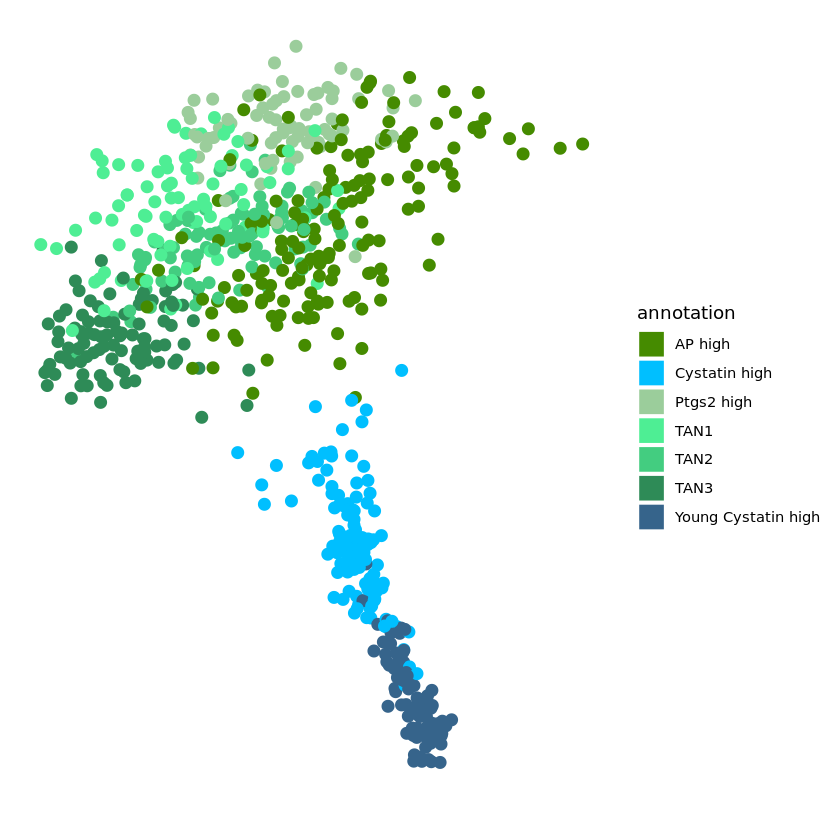

In [46]:
ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_point(size=3, show.legend = F) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_color_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), #legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

In [47]:
p = ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_point(size=3, show.legend = F) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_color_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), #legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave("neutrophil_singlet_figs/2d_visualization2.png", plot = p, dpi = 1200)
ggsave("neutrophil_singlet_figs/legend2.png", plot=l, dpi = 1200)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [60]:
df_2d = data.frame(x=m2d@sc_x[good_cellnames], 
                   y=m2d@sc_y[good_cellnames], 
                   Age=factor(mat@cell_metadata[good_cellnames, "Age"], levels=names(age_colors)))

In [61]:
p = ggplot(df_2d, aes(x=x, y=y, col=Age)) +
    geom_point(size=3, show.legend = F) +
    geom_bar(aes(y=0, fill=Age), stat="identity", color="white") +
    scale_color_manual(values = age_colors) +
    scale_fill_manual(values = age_colors) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), #legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave("neutrophil_singlet_figs/2d_ages.png", plot = p, dpi = 1200)
ggsave("neutrophil_singlet_figs/legend_ages.png", plot=l, dpi = 1200)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [50]:
all_mat = t(mat@mat[,good_cellnames])
lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

In [51]:
#gene_names = c("Ngp", "Camp", "Stfa1", 
#               "Stfa3", "Cstdc5", "Retnlg",
#               "Rps24", "Mpo", "Ly6c2",
#               "Ccrl2", "Sell", "Ier2",
#               "Ccl3", "Csf1", "Ier3",
#               "G0s2", "Cd74", "Btg2",
#               "Wfdc17", "Ifitm1", "Cd14")

gene_names = c("Retnlg", "Csf3r",  "Cxcl2", "Ngp", "Cstdc5", "Wfdc17", "Lrg1", "Trf")

df_2d = data.frame(x=m2d@sc_x[good_cellnames], 
                   y=m2d@sc_y[good_cellnames]) %>% 
    cbind(as.data.frame(as.matrix(lognorm_mat[good_cellnames, gene_names])))

gbs = lapply(gene_names, function(gene_name){

    ggplot(df_2d[order(df_2d[,gene_name], decreasing = F),], aes_string(x='x', y='y', col=gene_name)) +
        geom_point(size=0.5, show.legend = F) +
        scale_color_gradientn(colors=c("ivory2", "orange", "tomato", "mediumorchid4", "midnightblue"), na.value = "midnightblue", 
                              limits=c(0,7)) +
        labs(title = gene_name) +
        theme(plot.title = element_text(size = 12, hjust = 0.5, face = "bold"), 
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              legend.key.size = unit(0.25, 'cm'), legend.text =  element_text(size = 10))

})

g <- arrangeGrob(grobs=gbs, nrow=2, respect = T) #generates g
ggsave(file="neutrophil_singlet_figs/gene_projections_few.png", g, dpi = 1200) #saves g

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Saving 6.67 x 6.67 in image


In [52]:
ages = age_order = c("10d", "3w", "6w", "8w", "10w", "12w")
conditions = cond_order = c("tumor", "normal")

In [53]:
full_df = cbind(mat@cell_metadata[names(mc@mc),], annotation=mc@annots[mc@mc])

In [54]:
sum_df = full_df %>%
    filter(Cell_type == "LY6G", condition == "tumor") %>%
    group_by(annotation, Age, Replicate) %>% 
    summarise(Count=n()) %>%
    group_by(Age, Replicate) %>% 
    summarise(Replicate=Replicate, 
              Age=Age,
              annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    group_by(annotation, Age) %>%
    summarise(Age=Age, 
              annotation=annotation,
              mean_fraction = mean(fraction)) %>%
    as.data.frame

sum_df$annotation = factor(sum_df$annotation, levels=cell_order)
sum_df$Age = as.character(sum_df$Age)
sum_df = sum_df %>% tidyr::complete(annotation, Age, fill=list(mean_fraction=0))
sum_df$Age = factor(sum_df$Age, levels=age_order)
group.colors = annot_df$color[match(cell_order, annot_df$label)]
names(group.colors) = cell_order
#sum_df = remove_missing(sum_df)

`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'Replicate'. You can override using
the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.


In [55]:
table(full_df[full_df$condition == "normal",c('Age', 'annotation')])[age_order,cell_order]

     annotation
Age   Young Cystatin high Cystatin high AP high Ptgs2 high TAN1 TAN2 TAN3
  10d                  57            75       6          1    1    1    0
  3w                    2             1      12          2    4    0    0
  6w                    1             0       8          2    2    0    1
  8w                    0             0       1          0    1    0    0
  10w                   0             0       6          2    0    0    0
  12w                   0             0       9          2    2    0    0

In [56]:
table(full_df[full_df$condition == "tumor",c('Age', 'annotation')])[age_order,cell_order]

     annotation
Age   Young Cystatin high Cystatin high AP high Ptgs2 high TAN1 TAN2 TAN3
  10d                  25            38       8          4    1    0    1
  3w                    0             0      25          6    5    1    2
  6w                    0             0       5          7    2    1    2
  8w                    1             0      25         18   20    8    6
  10w                   1             0      23         18   26    7   11
  12w                   8             3      39         15   20   81   75

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.0302”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”
Warning m

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.0302”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal con

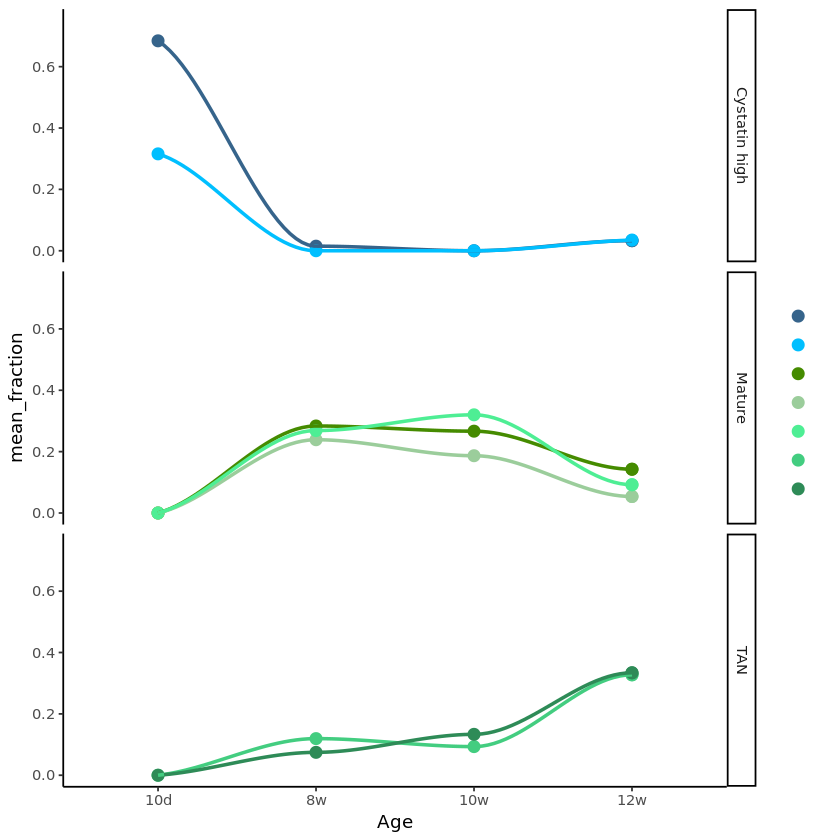

In [62]:
sum_df %>%
    mutate(grouped_cell = ifelse(annotation %in% cell_order[1:2], "Cystatin high", 
                                 ifelse(annotation %in% cell_order[3:5], "Mature", "TAN"))) %>%
ggplot(aes(x=Age, y=mean_fraction, color=annotation, group=annotation)) +
    geom_point(size=3) +
    geom_smooth(show.legend = F, se = F) +
    scale_color_manual(values = group.colors) +
    scale_y_continuous(limits = c(0,0.75)) +
    facet_grid(rows='grouped_cell') +
    theme(legend.text = element_blank(), legend.title=element_blank())

ggsave("neutrophil_singlet_figs/tumor_composition_smoothed.png", dpi=1200, width=5, height=7)

In [63]:
nms = choose_genes_from_clust('neutrophil_mc', 
                              'neutrophil_singlets', 
                              good_clusts = c(8,7,2,1,4:6),
                              nms_per_clust=100,
                              nms_thresh=1,
                              ord = "max.col", 
                              bad_genes = bad_genes,
                              must_haves = c())

In [64]:
cat(rev(nms), sep='", "')

Wfdc17", "Ifitm1", "Lrg1", "Trf", "Csn3", "Rhog", "Cxcl2", "Ccrl2", "Nfkbia", "Tnfaip3", "Marcksl1", "Ier3", "Ppp1r15a", "Ptgs2", "Nfkbid", "Gadd45b", "Ccl3", "Nfkbie", "Egr1", "Cd74", "H2-Aa", "Ccl6", "Csta3", "Retnla", "S100a9", "S100a8", "Cstdc5", "Retnlg", "Cstdc4", "Stfa2", "Stfa2l1", "Lyz2", "Camp", "Ngp", "Stfa3", "Anxa1", "Lcn2", "Pglyrp1", "Wfdc21", "Cstdc6", "Ltf", "Arhgdib", "Ifitm6", "Prdx5", "Chil3", "Mmp8", "Thbs1", "Olfm4", "Cd177", "Ly6a2", "Stfa1", "Adpgk

In [65]:
manual_order_nms = c("S100a9", "S100a8", "Wfdc17", "Ifitm2", "Ifitm1", "Lrg1", "Rhog", "Socs3", 
                     "Cxcl2", "Ccrl2", "Nfkbia", "Tnfaip3", "Marcksl1", "Ier3", "Ppp1r15a", "Ptgs2", "Nfkbid", "Gadd45b", "Ccl3", 
                     "Egr1", "H2-Ab1", "Cd74", "H2-Aa", "Ccl6", 
                     "Retnla", "Cstdc6", "Cstdc5", "Cstdc4", "Csta3", "Stfa3", "Stfa2", "Stfa2l1", "Stfa1", "Prdx5", 
                     "Retnlg", "Lyz2", "Anxa1", "Lcn2", "Pglyrp1", "Wfdc21", 
                     "Camp", "Ngp", "Ltf", "Arhgdib", "Ifitm6", "Mmp8", "Thbs1", "Cd177", "Ly6a2", "Adpgk") %>% rev

In [66]:
cat(manual_order_nms, sep='\n')

Adpgk
Ly6a2
Cd177
Thbs1
Mmp8
Ifitm6
Arhgdib
Ltf
Ngp
Camp
Wfdc21
Pglyrp1
Lcn2
Anxa1
Lyz2
Retnlg
Prdx5
Stfa1
Stfa2l1
Stfa2
Stfa3
Csta3
Cstdc4
Cstdc5
Cstdc6
Retnla
Ccl6
H2-Aa
Cd74
H2-Ab1
Egr1
Ccl3
Gadd45b
Nfkbid
Ptgs2
Ppp1r15a
Ier3
Marcksl1
Tnfaip3
Nfkbia
Ccrl2
Cxcl2
Socs3
Rhog
Lrg1
Ifitm1
Ifitm2
Wfdc17
S100a8
S100a9


In [67]:
focus_mc_nums = 1:8
focus_mcs = match(mc@annots[mc@mc[mc@mc %in% focus_mc_nums]], cell_order) * 1000 + mc@mc[mc@mc %in% focus_mc_nums]
focus_mat = t(mat@mat[rowSums(mat@mat) > 0,names(focus_mcs[order(focus_mcs, decreasing = F)])])
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))    
#focus_mat_norm = scale(focus_mat_norm)

heatmap_df = as.matrix(t(focus_mat_norm[,manual_order_nms]))
ha = HeatmapAnnotation(Type=factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]), 
                       Age=factor(mat@cell_metadata[colnames(heatmap_df),'Age'], levels=age_order),
                       col = list(Type=group.colors, Age=age_colors))

png(file=paste0("neutrophil_singlet_figs/complexheatmap_manual_lfc_over1.png"), 
    width     = 6,
    height    = 5,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

h = Heatmap(heatmap_df, row_names_gp = gpar(fontsize=6),
            column_split =  factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order),
            heatmap_legend_param = list(labels_gp = gpar(fontsize = 10)),
            cluster_rows = F, cluster_columns =  F, top_annotation = ha, # show_column_dend = F,
            bottom_annotation = ha, show_column_names = F, name="Log normalized UMIs",
            #col = circlize::colorRamp2(c(-2, 0, 2), c("navy", "white", "red")))
            col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(1000), use_raster = F)
plot(h)
dev.off()

png 
  2

In [68]:
modify_facet_appearance <- function(plot = NULL,
                                    strip.background.x.fill = NULL, 
                                    strip.background.y.fill = NULL,
                                    strip.background.x.col = NULL,
                                    strip.background.y.col = NULL,
                                    strip.text.x.col = NULL,
                                    strip.text.y.col = NULL){
  
  if(is.null(plot)){stop("A ggplot (gg class) needs to be provided!")}
  
  # Generate gtable object to modify the facet strips:
  g <- ggplot_gtable(ggplot_build(plot))
  
  # Get the locations of the right and top facets in g:
  stripy <- which(grepl('strip-r|strip-l', g$layout$name)) # account for when strip positions are switched r-l and/or t-b in facet_grid(switch = )
  stripx <- which(grepl('strip-t|strip-b', g$layout$name))
  
  # Check that the provided value arrays have the same length as strips the plot has:
  lx <- c(length(strip.background.x.fill), length(strip.background.x.col), length(strip.text.x.col))
  if(!all(lx==length(stripx) | lx==0)){stop("The provided vectors with values need to have the same length and the number of facets in the plot!")}
  ly <- c(length(strip.background.y.fill), length(strip.background.y.col), length(strip.text.y.col))
  if(!all(ly==length(stripy) | ly==0)){stop("The provided vectors with values need to have the same length and the number of facets in the plot!")}
  
  # Change the strips on the y axis:
  for (i in seq_along(stripy)){ # if no strips in the right, the loop will not be executed as seq_along(stripy) will be integer(0)
    
    # Change strip fill and (border) colour :
    j1 <- which(grepl('strip.background.y', g$grobs[[stripy[i]]]$grobs[[1]]$childrenOrder))
    if(!is.null(strip.background.y.fill[i])){g$grobs[[stripy[i]]]$grobs[[1]]$children[[j1]]$gp$fill <- strip.background.y.fill[i]} # fill
    if(!is.null(strip.background.y.col[i])){g$grobs[[stripy[i]]]$grobs[[1]]$children[[j1]]$gp$col <- strip.background.y.col[i]} # border colour
    
    # Change color of text:
    j2 <- which(grepl('strip.text.y', g$grobs[[stripy[i]]]$grobs[[1]]$childrenOrder))
    if(!is.null(strip.text.y.col[i])){g$grobs[[stripy[i]]]$grobs[[1]]$children[[j2]]$children[[1]]$gp$col <- strip.text.y.col[i]}

  }
  
  # Same but for the x axis:
  for (i in seq_along(stripx)){
    
    # Change strip fill and (border) colour :
    j1 <- which(grepl('strip.background.x', g$grobs[[stripx[i]]]$grobs[[1]]$childrenOrder))
    if(!is.null(strip.background.x.fill[i])){g$grobs[[stripx[i]]]$grobs[[1]]$children[[j1]]$gp$fill <- strip.background.x.fill[i]} # fill
    if(!is.null(strip.background.x.col[i])){g$grobs[[stripx[i]]]$grobs[[1]]$children[[j1]]$gp$col <- strip.background.x.col[i]} # border colour
    
    # Change color of text:
    j2 <- which(grepl('strip.text.x', g$grobs[[stripx[i]]]$grobs[[1]]$childrenOrder))
    if(!is.null(strip.text.x.col[i])){g$grobs[[stripx[i]]]$grobs[[1]]$children[[j2]]$children[[1]]$gp$col <- strip.text.x.col[i]}

  }
  
  return(g) 
  
  # Note that it returns a gtable object. This can be ploted with plot() or grid::draw.grid(). 
  # patchwork can handle the addition of such gtable to a layout with other ggplot objects, 
  # but be sure to use patchwork::wrap_ggplot_grob(g) for proper alignment of plots!
  # See: https://patchwork.data-imaginist.com/reference/wrap_ggplot_grob.html
  
}


In [70]:
plot_features = c("Ngp", "Cstdc4", #"Cstdc5", "Cstdc6", "Stfa2", "Stfa3", "Arhgdib", "Stfa2l1", 
                  "H2-Aa",
                  "Cxcl2", "Ptgs2",
                  "Ifitm1", "Wfdc17", 
                  "Wfdc21", "Lcn2", "Retnlg")#,"Hdc", "Wfdc17", "Lilrb4b", "Socs3", "Cd14", "Il1b")

In [73]:
barplot_df = cbind(as.data.frame(lognorm_mat[,plot_features] %>% as.matrix), 
                   age=as.character(mat@cell_metadata[rownames(lognorm_mat),'Age']),
                   annots=mc@annots[mc@mc[rownames(lognorm_mat)]]) %>%
    rownames_to_column('cell_name') %>%
    melt(variable.name = 'Gene', value.name = 'LogNormExpression') %>%
    mutate(age=factor(age, levels=ages), annots=factor(annots, levels=cell_order))

Using cell_name, age, annots as id variables



In [74]:
bar_df = barplot_df %>% 
    group_by(age) %>% 
    summarise(annots=annots, Gene=Gene, LogNormExpression=LogNormExpression, ncells=length(unique(cell_name))) %>%
    group_by(age, annots, Gene) %>%
    summarise(sum_expression=sum(LogNormExpression), norm_sum=sum(LogNormExpression)/ncells[1], mean_expr=mean(LogNormExpression))

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'age', 'annots'. You can override using the
`.groups` argument.


In [75]:
p = ggplot(bar_df, aes(x=annots, y=norm_sum, fill=annots)) +
    geom_bar(stat='identity', show.legend = F) +
    facet_grid(Gene ~ age, scales = 'free_y', ) +
    scale_fill_manual(values = group.colors) +
    #scale_y_continuous(n.breaks = 3) +
    theme(strip.background.y = element_blank(), strip.background.x = element_rect(color = NA),
          axis.title.x = element_blank(), axis.line.x = element_blank(), axis.text.x = element_blank(), 
          axis.ticks.x = element_blank())

p = modify_facet_appearance(p, strip.background.x.fill = age_colors, strip.text.x.col = age_colors)

ggsave("final_figs/fig4/gene_barplot.png", dpi=1200, plot=p, height = 8, width = 5)